In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-11 12:54:49.348821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 12:54:49.348873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [13]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [15]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [16]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Generic Autoencoders

In [18]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:2553.2620, Loss-ae:2553.2620, Loss-topo:2.2038
Epoch:2, P:None, Loss:2606.1357, Loss-ae:2606.1357, Loss-topo:1.8860
Epoch:3, P:None, Loss:2565.0212, Loss-ae:2565.0212, Loss-topo:2.3499
Epoch:4, P:None, Loss:2572.6013, Loss-ae:2572.6013, Loss-topo:2.2080
Epoch:5, P:None, Loss:2581.8088, Loss-ae:2581.8088, Loss-topo:2.4745
Epoch:6, P:None, Loss:2572.5171, Loss-ae:2572.5171, Loss-topo:3.7669
Epoch:7, P:None, Loss:2567.6022, Loss-ae:2567.6022, Loss-topo:5.1871
Epoch:8, P:None, Loss:2606.4669, Loss-ae:2606.4669, Loss-topo:6.2383
Epoch:9, P:None, Loss:2587.2061, Loss-ae:2587.2061, Loss-topo:6.1463
Epoch:10, P:None, Loss:2557.0043, Loss-ae:2557.0043, Loss-topo:4.2752
Epoch:11, P:None, Loss:2580.0752, Loss-ae:2580.0752, Loss-topo:5.3020
Epoch:12, P:None, Loss:2585.0424, Loss-ae:2585.0424, Loss-topo:5.8953
Epoch:13, P:None, Loss:2584.5958, Loss-ae:2584.5958, Loss-topo:12.2874
Epoch:14, P:None, Loss:2581.4957, Loss-ae:2581.4957, Loss-topo:14.0776
Epoch:15, P:None, Loss:2559

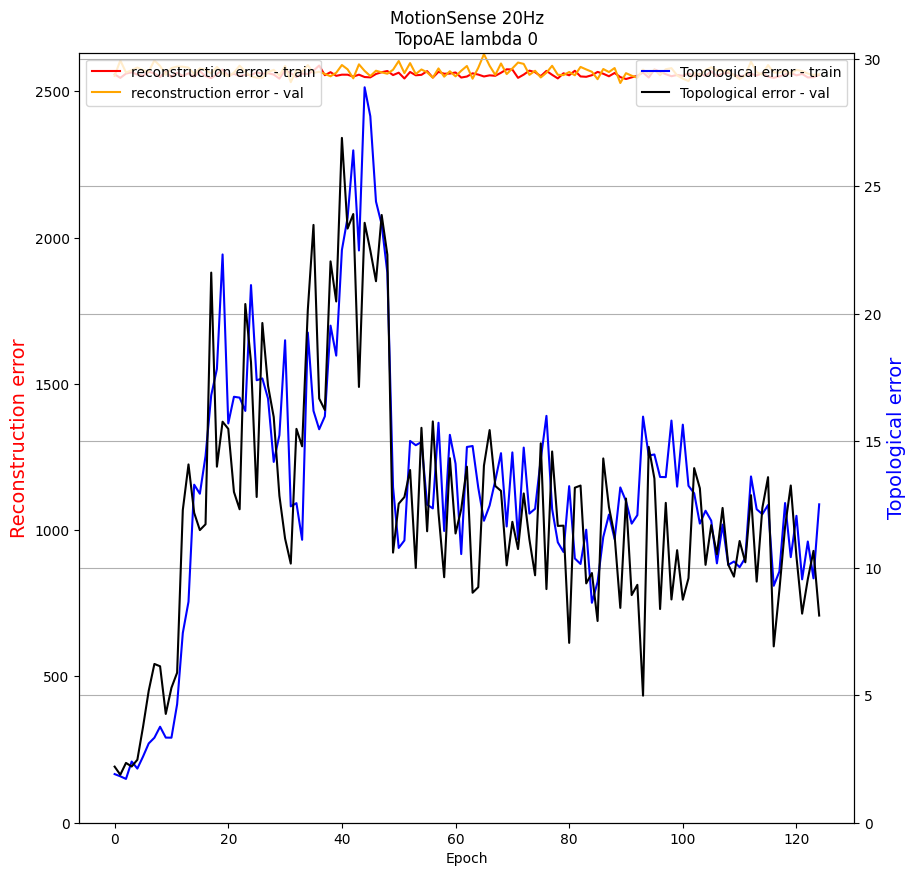

In [19]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [20]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [21]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [22]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6923529411764706,
 'RF-F1': 0.6931664752462858,
 'SVC-ACC': 0.6431372549019608,
 'SVC-F1': 0.6476197901944825,
 'KNN-ACC': 0.6803921568627451,
 'KNN-F1': 0.6768018840700947}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


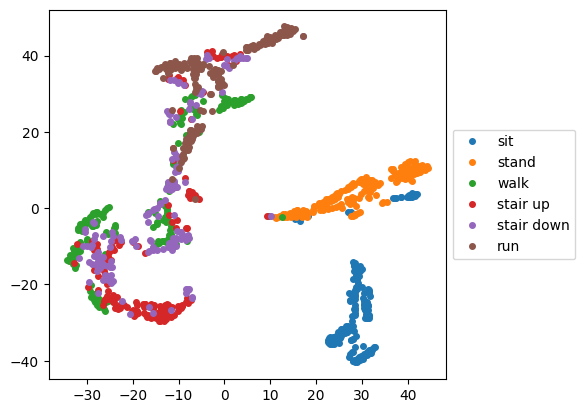

In [23]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [24]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:2575.1146, Loss-ae:2574.9058, Loss-topo:0.2088
Epoch:2, P:None, Loss:2569.5623, Loss-ae:2569.4490, Loss-topo:0.1133
Epoch:3, P:None, Loss:2576.9888, Loss-ae:2576.8834, Loss-topo:0.1053
Epoch:4, P:None, Loss:2561.1582, Loss-ae:2561.1033, Loss-topo:0.0549
Epoch:5, P:None, Loss:2574.6905, Loss-ae:2574.5872, Loss-topo:0.1033
Epoch:6, P:None, Loss:2577.6393, Loss-ae:2577.4073, Loss-topo:0.2320
Epoch:7, P:None, Loss:2582.5434, Loss-ae:2582.3133, Loss-topo:0.2300
Epoch:8, P:None, Loss:2592.0165, Loss-ae:2591.9039, Loss-topo:0.1126
Epoch:9, P:None, Loss:2565.9782, Loss-ae:2565.9039, Loss-topo:0.0743
Epoch:10, P:None, Loss:2551.0065, Loss-ae:2550.9238, Loss-topo:0.0828
Epoch:11, P:None, Loss:2556.3531, Loss-ae:2556.2914, Loss-topo:0.0618
Epoch:12, P:None, Loss:2595.0658, Loss-ae:2594.9844, Loss-topo:0.0814
Epoch:13, P:None, Loss:2570.4222, Loss-ae:2569.7219, Loss-topo:0.7003
Epoch:14, P:None, Loss:2567.8615, Loss-ae:2567.4586, Loss-topo:0.4029
Epoch:15, P:None, Loss:2562.2

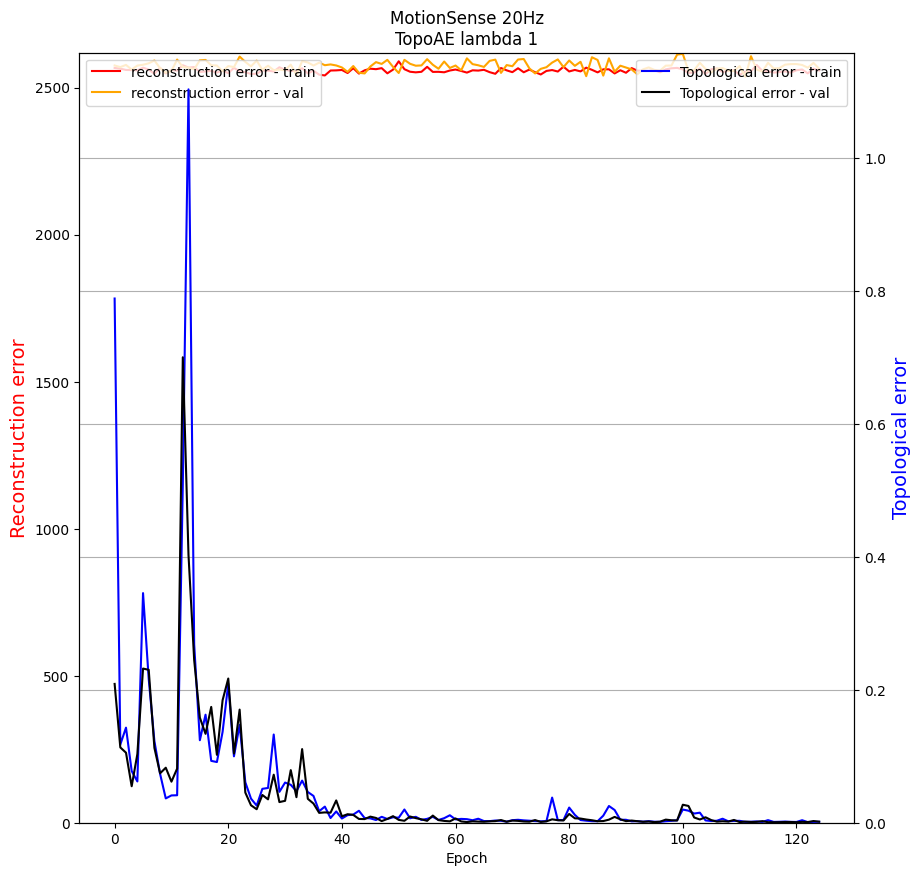

In [25]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [26]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [27]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [28]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7899999999999999,
 'RF-F1': 0.7897812711097599,
 'SVC-ACC': 0.7813725490196078,
 'SVC-F1': 0.7851372790144039,
 'KNN-ACC': 0.7470588235294118,
 'KNN-F1': 0.7441177835004369}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


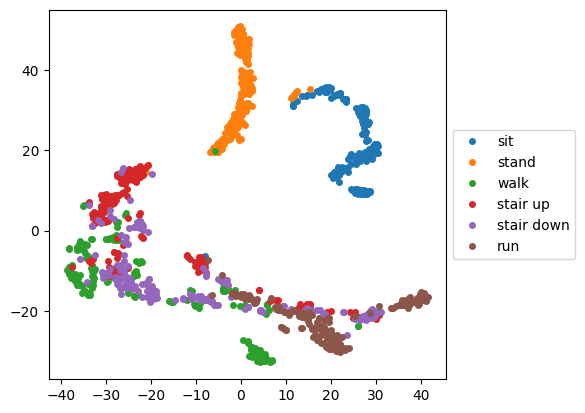

In [29]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [30]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:2580.2228, Loss-ae:2579.8643, Loss-topo:0.0717
Epoch:2, P:None, Loss:2574.5822, Loss-ae:2574.4514, Loss-topo:0.0262
Epoch:3, P:None, Loss:2584.5998, Loss-ae:2584.5350, Loss-topo:0.0130
Epoch:4, P:None, Loss:2586.4074, Loss-ae:2586.3265, Loss-topo:0.0162
Epoch:5, P:None, Loss:2560.7554, Loss-ae:2560.6610, Loss-topo:0.0189
Epoch:6, P:None, Loss:2572.9113, Loss-ae:2572.6382, Loss-topo:0.0546
Epoch:7, P:None, Loss:2569.8795, Loss-ae:2569.8120, Loss-topo:0.0135
Epoch:8, P:None, Loss:2589.2379, Loss-ae:2588.9525, Loss-topo:0.0571
Epoch:9, P:None, Loss:2561.3586, Loss-ae:2561.0942, Loss-topo:0.0529
Epoch:10, P:None, Loss:2548.4970, Loss-ae:2548.4471, Loss-topo:0.0100
Epoch:11, P:None, Loss:2558.7153, Loss-ae:2558.6233, Loss-topo:0.0184
Epoch:12, P:None, Loss:2556.1836, Loss-ae:2554.7782, Loss-topo:0.2811
Epoch:13, P:None, Loss:2582.9665, Loss-ae:2582.6557, Loss-topo:0.0622
Epoch:14, P:None, Loss:2574.0520, Loss-ae:2573.9817, Loss-topo:0.0141
Epoch:15, P:None, Loss:2579.5

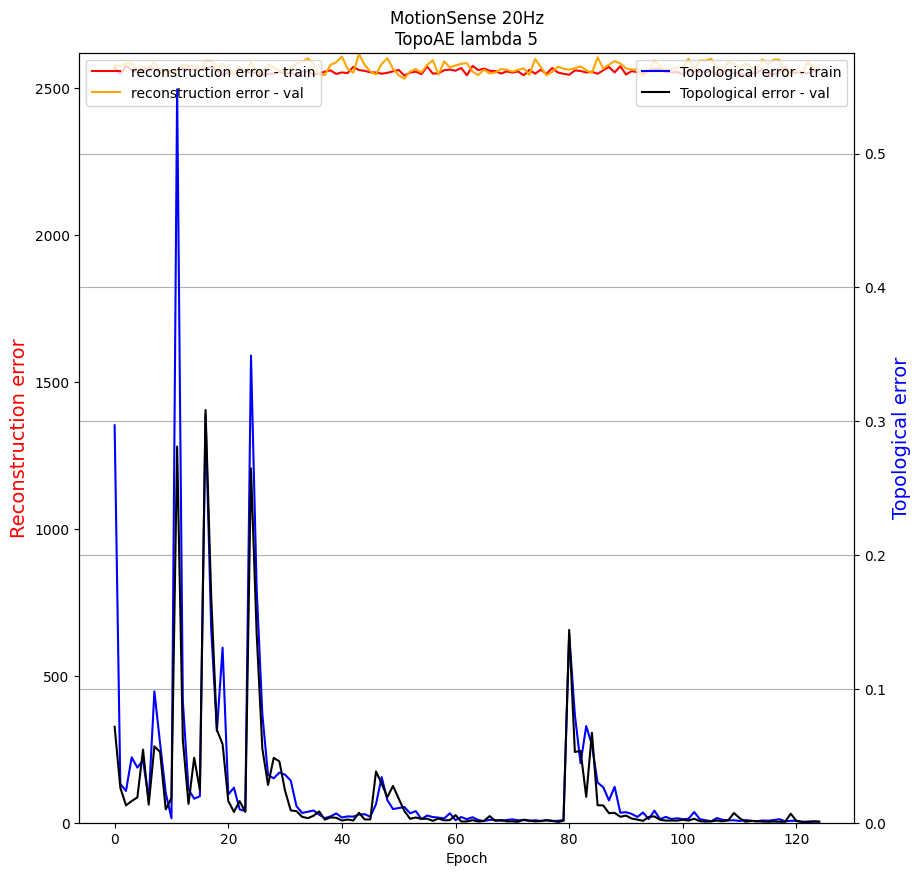

In [31]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [32]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [33]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [34]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7787254901960784,
 'RF-F1': 0.7834310197375658,
 'SVC-ACC': 0.7578431372549019,
 'SVC-F1': 0.7623063111219782,
 'KNN-ACC': 0.75,
 'KNN-F1': 0.7498146728111645}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


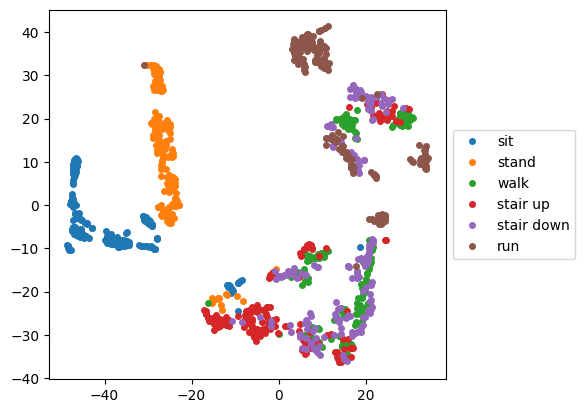

In [35]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [36]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:2549.6093, Loss-ae:2549.3992, Loss-topo:0.0210
Epoch:2, P:None, Loss:2608.0043, Loss-ae:2607.8240, Loss-topo:0.0180
Epoch:3, P:None, Loss:2554.3195, Loss-ae:2554.2637, Loss-topo:0.0056
Epoch:4, P:None, Loss:2576.1265, Loss-ae:2576.0822, Loss-topo:0.0044
Epoch:5, P:None, Loss:2584.2493, Loss-ae:2584.1459, Loss-topo:0.0103
Epoch:6, P:None, Loss:2583.5400, Loss-ae:2583.5171, Loss-topo:0.0023
Epoch:7, P:None, Loss:2581.8031, Loss-ae:2581.6815, Loss-topo:0.0122
Epoch:8, P:None, Loss:2582.7718, Loss-ae:2582.3010, Loss-topo:0.0471
Epoch:9, P:None, Loss:2587.7203, Loss-ae:2587.4732, Loss-topo:0.0247
Epoch:10, P:None, Loss:2581.7570, Loss-ae:2581.6150, Loss-topo:0.0142
Epoch:11, P:None, Loss:2579.5746, Loss-ae:2579.2852, Loss-topo:0.0289
Epoch:12, P:None, Loss:2605.4035, Loss-ae:2604.9626, Loss-topo:0.0441
Epoch:13, P:None, Loss:2563.4277, Loss-ae:2563.3863, Loss-topo:0.0041
Epoch:14, P:None, Loss:2590.2147, Loss-ae:2590.1915, Loss-topo:0.0023
Epoch:15, P:None, Loss:2588.4

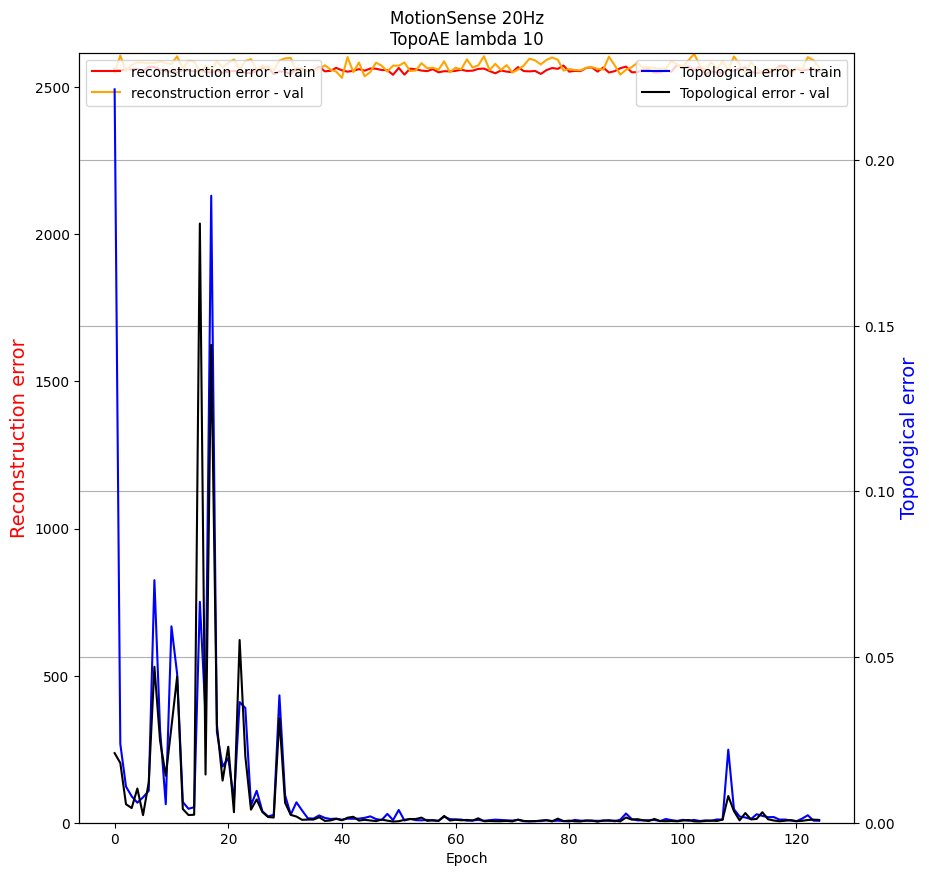

In [37]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [38]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [39]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [40]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7464705882352941,
 'RF-F1': 0.744121256586571,
 'SVC-ACC': 0.7225490196078431,
 'SVC-F1': 0.7219487793495262,
 'KNN-ACC': 0.7333333333333333,
 'KNN-F1': 0.7287705704477526}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


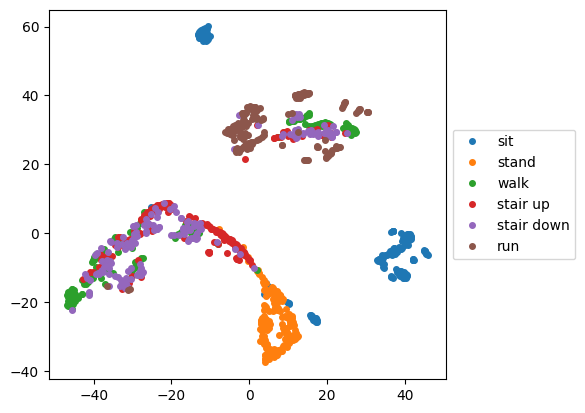

In [41]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [42]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:2572.8469, Loss-ae:2572.2032, Loss-topo:0.0064
Epoch:2, P:None, Loss:2577.1278, Loss-ae:2577.0645, Loss-topo:0.0006
Epoch:3, P:None, Loss:2576.7865, Loss-ae:2576.2998, Loss-topo:0.0049
Epoch:4, P:None, Loss:2562.0528, Loss-ae:2561.6643, Loss-topo:0.0039
Epoch:5, P:None, Loss:2548.0104, Loss-ae:2547.5922, Loss-topo:0.0042
Epoch:6, P:None, Loss:2558.8861, Loss-ae:2558.7952, Loss-topo:0.0009
Epoch:7, P:None, Loss:2598.8477, Loss-ae:2598.7401, Loss-topo:0.0011
Epoch:8, P:None, Loss:2565.0999, Loss-ae:2564.1076, Loss-topo:0.0099
Epoch:9, P:None, Loss:2574.0020, Loss-ae:2573.7847, Loss-topo:0.0022
Epoch:10, P:None, Loss:2545.6871, Loss-ae:2545.5095, Loss-topo:0.0018
Epoch:11, P:None, Loss:2588.4961, Loss-ae:2587.4655, Loss-topo:0.0103
Epoch:12, P:None, Loss:2571.3699, Loss-ae:2568.6534, Loss-topo:0.0272
Epoch:13, P:None, Loss:2578.0568, Loss-ae:2577.9101, Loss-topo:0.0015
Epoch:14, P:None, Loss:2561.5181, Loss-ae:2561.1233, Loss-topo:0.0039
Epoch:15, P:None, Loss:2577.3

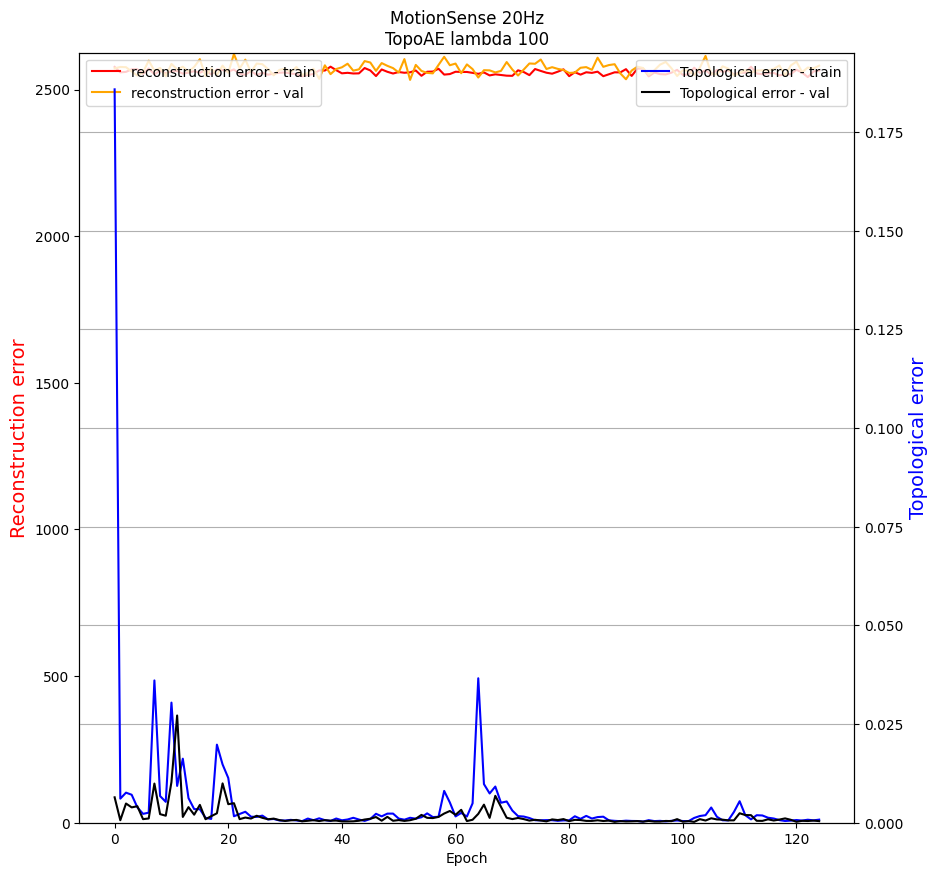

In [43]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [44]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [45]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [46]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7912745098039216,
 'RF-F1': 0.7907077223766399,
 'SVC-ACC': 0.8333333333333334,
 'SVC-F1': 0.8352643118430877,
 'KNN-ACC': 0.8098039215686275,
 'KNN-F1': 0.8134784751398974}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


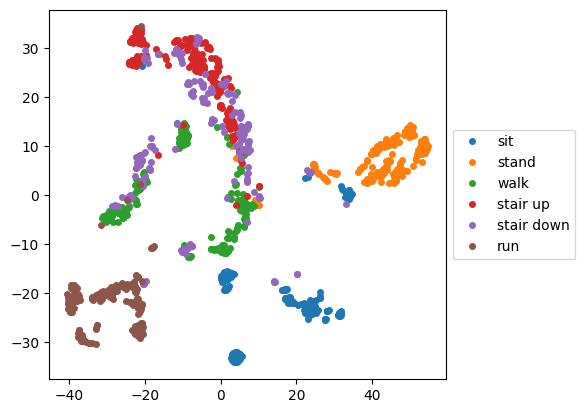

In [47]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [48]:
# Reducing with Convolutional Topological Autoencoders

In [49]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [50]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [51]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [52]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [53]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result